In [1]:
# import the necessary packages
from  tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs,and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

## Loading and pre-processing our training data

In [3]:
#Our training data contained image with mask and without mask
imagePaths_mask = []
imagePaths_without_mask = []

for filename in os.listdir("data/with_mask"):
  imagePaths_mask.append(filename)
for filename in os.listdir("data/without_mask"):
  imagePaths_without_mask.append(filename)

In [4]:
data = []
labels = []

for img in imagePaths_mask:

  label = 'with_mask'

  image = load_img("data/with_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

for img in imagePaths_without_mask:

  label = 'without_mask'

  image = load_img("data/without_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

d:\anaconda3\envs\face_mask\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Performing one-hot encoding on the labels

In [5]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


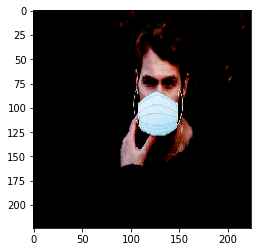

In [6]:
plt.imshow(data[0])

In [7]:
# split training and testing data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [8]:
#Initialising ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
# load the MobileNetV2 network and fine tuning it
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

## Defining final model

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
#freezing base model's layers
for layer in baseModel.layers:
    baseModel.trainable = False

In [14]:
# compile our model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

## Fitting our model

In [15]:
history = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose = 1)

Epoch 1/20
188/188 [==============================] - 188s 982ms/step - loss: 0.4467 - accuracy: 0.8081 - val_loss: 0.0895 - val_accuracy: 0.9782
Epoch 2/20
188/188 [==============================] - 151s 800ms/step - loss: 0.1038 - accuracy: 0.9751
Epoch 3/20
188/188 [==============================] - 164s 873ms/step - loss: 0.0706 - accuracy: 0.9789
Epoch 4/20
188/188 [==============================] - 164s 870ms/step - loss: 0.0616 - accuracy: 0.9813
Epoch 5/20
188/188 [==============================] - 152s 803ms/step - loss: 0.0515 - accuracy: 0.9868
Epoch 6/20
188/188 [==============================] - 146s 776ms/step - loss: 0.0449 - accuracy: 0.9875
Epoch 7/20
188/188 [==============================] - 163s 864ms/step - loss: 0.0375 - accuracy: 0.9888
Epoch 8/20
188/188 [==============================] - 183s 969ms/step - loss: 0.0367 - accuracy: 0.9866
Epoch 9/20
188/188 [==============================] - 181s 960ms/step - loss: 0.0380 - accuracy: 0.9879
Epoch 10/20
188/188 [=

## Save our model into .pb and .h5 format

In [16]:
model.save("models")  # as .pb
model.save("models/face_model.h5")  # as .h5

INFO:tensorflow:Assets written to: models\assets


## Model Evaluation

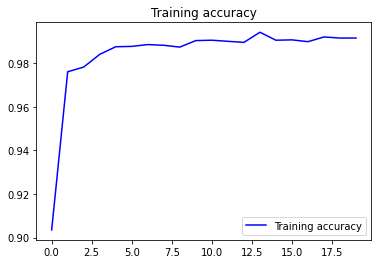

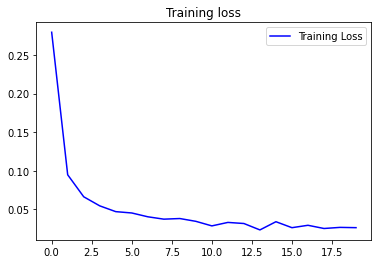

In [17]:
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()